In [ ]:
!pip install jovian --upgrade --quiet

     |████████████████████████████████| 71kB 2.6MB/s 


In [ ]:
pip install jovian --upgrade

Requirement already up-to-date: jovian in /usr/local/lib/python3.7/dist-packages (0.2.41)


In [ ]:
import jovian

In [ ]:
jovian.commit(project='01-pytorch-basics')

[jovian] Detected Colab notebook...


[jovian] Error: jovian.commit doesn't work on Colab unless the notebook was created and executed from Jovian.
Make sure to run the first code cell at the top after executing from Jovian.
Alternatively, you can download this notebook and upload it manually to Jovian.
Learn more: https://jovian.ai/docs/user-guide/run.html#run-on-colab


#Introduction to Linear Regression
In this tutorial, we'll discuss one of the foundational algorithms in machine learning: Linear regression. We'll create a model that predicts crop yields for apples and oranges (target variables) by looking at the average temperature, rainfall, and humidity (input variables or features) in a region. Here's the training data:

linear-regression-training-data

In a linear regression model, each target variable is estimated to be a weighted sum of the input variables, offset by some constant, known as a bias :

yield_apple  = w11 * temp + w12 * rainfall + w13 * humidity + b1

yield_orange = w21 * temp + w22 * rainfall + w23 * humidity + b2

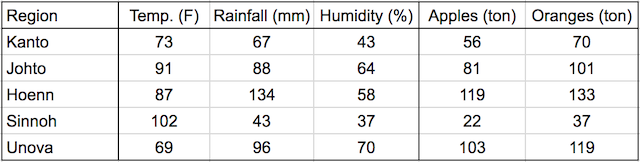

In [ ]:
import numpy as np
import torch

#**Training data**
 
We can represent the training data using two matrices: inputs and targets, each with one row per observation, and one column per variable.

In [ ]:
# Input (temp, rainfall, humidity)


inputs = np.array([[73, 67, 43], 
                   [91, 88, 64], 
                   [87, 134, 58], 
                   [102, 43, 37], 
                   [69, 96, 70]], dtype='float32')

In [ ]:

targets = np.array([[56, 70], 
                    [81, 101], 
                    [119, 133], 
                    [22, 37], 
                    [103, 119]], dtype='float32')

Let's convert the arrays to PyTorch tensors.


In [ ]:
inputs=torch.from_numpy(inputs)
targets=torch.from_numpy(targets)
print(inputs)
print(targets)

tensor([[ 73.,  67.,  43.],
        [ 91.,  88.,  64.],
        [ 87., 134.,  58.],
        [102.,  43.,  37.],
        [ 69.,  96.,  70.]])
tensor([[ 56.,  70.],
        [ 81., 101.],
        [119., 133.],
        [ 22.,  37.],
        [103., 119.]])


##Linear regression model from scratch
The weights and biases (w11, w12,... w23, b1 & b2) can also be represented as matrices, initialized as random values. The first row of w and the first element of b are used to predict the first target variable, i.e., yield of apples, and similarly, the second for oranges.

In [ ]:
# initialising randon values of w and b
w=torch.randn(2,3,requires_grad=True)
b=torch.randn(2,requires_grad=True)
print(w)
print(b)

tensor([[-0.0951,  0.6222,  1.0397],
        [ 0.3083,  0.3267, -0.3461]], requires_grad=True)
tensor([-1.6112,  1.2241], requires_grad=True)


`torch.randn` creates a tensor with the given shape, with elements picked randomly from a [normal distribution](https://en.wikipedia.org/wiki/Normal_distribution) with mean 0 and standard deviation 1.

Our *model* is simply a function that performs a matrix multiplication of the `inputs` and the weights `w` (transposed) and adds the bias `b` (replicated for each observation).

![matrix-mult](https://i.imgur.com/WGXLFvA.png)

We can define the model as follows:

In [ ]:
# defining model 
def model(x):
  return x @ w.t() +b

`@` represents matrix multiplication in PyTorch, and the `.t` method returns the transpose of a tensor.

The matrix obtained by passing the input data into the model is a set of predictions for the target variables.

In [ ]:
# Generate predictions
preds = model(inputs)
print(preds)

tensor([[ 77.8378,  30.7359],
        [111.0250,  35.8774],
        [133.7878,  51.7487],
        [ 53.9083,  33.9133],
        [124.3336,  29.6311]], grad_fn=<AddBackward0>)


In [ ]:
# compare with targets
print(targets)

tensor([[ 56.,  70.],
        [ 81., 101.],
        [119., 133.],
        [ 22.,  37.],
        [103., 119.]])


## Loss function

Before we improve our model, we need a way to evaluate how well our model is performing. We can compare the model's predictions with the actual targets using the following method:

* Calculate the difference between the two matrices (`preds` and `targets`).
* Square all elements of the difference matrix to remove negative values.
* Calculate the average of the elements in the resulting matrix.

The result is a single number, known as the **mean squared error** (MSE).

In [ ]:
def mse(t1, t2):
    diff = t1 - t2
    return torch.sum(diff * diff) / diff.numel()
loss=mse(preds,targets)
print(loss)


tensor(2345.1050, grad_fn=<DivBackward0>)


Here’s how we can interpret the result: *On average, each element in the prediction differs from the actual target by the square root of the loss*. And that’s pretty bad, considering the numbers we are trying to predict are themselves in the range 50–200. The result is called the *loss* because it indicates how bad the model is at predicting the target variables. It represents information loss in the model: the lower the loss, the better the model.

## Compute gradients

With PyTorch, we can automatically compute the gradient or derivative of the loss w.r.t. to the weights and biases because they have `requires_grad` set to `True`. We'll see how this is useful in just a moment.

In [ ]:
# Compute gradients
loss.backward()

The gradients are stored in the `.grad` property of the respective tensors. Note that the derivative of the loss w.r.t. the weights matrix is itself a matrix with the same dimensions.

In [ ]:
print(w)
print(w.grad)

tensor([[-0.0951,  0.6222,  1.0397],
        [ 0.3083,  0.3267, -0.3461]], requires_grad=True)
tensor([[ 2067.9270,  1901.3962,  1278.4551],
        [-4468.5200, -5592.2598, -3387.7622]])


## Adjust weights and biases to reduce the loss

The loss is a [quadratic function](https://en.wikipedia.org/wiki/Quadratic_function) of our weights and biases, and our objective is to find the set of weights where the loss is the lowest. If we plot a graph of the loss w.r.t any individual weight or bias element, it will look like the figure shown below. An important insight from calculus is that the gradient indicates the rate of change of the loss, i.e., the loss function's [slope](https://en.wikipedia.org/wiki/Slope) w.r.t. the weights and biases.

If a gradient element is **positive**:

* **increasing** the weight element's value slightly will **increase** the loss
* **decreasing** the weight element's value slightly will **decrease** the loss

![postive-gradient](https://i.imgur.com/WLzJ4xP.png)

If a gradient element is **negative**:

* **increasing** the weight element's value slightly will **decrease** the loss
* **decreasing** the weight element's value slightly will **increase** the loss

![negative=gradient](https://i.imgur.com/dvG2fxU.png)

The increase or decrease in the loss by changing a weight element is proportional to the gradient of the loss w.r.t. that element. This observation forms the basis of _the gradient descent_ optimization algorithm that we'll use to improve our model (by _descending_ along the _gradient_).

We can subtract from each weight element a small quantity proportional to the derivative of the loss w.r.t. that element to reduce the loss slightly.

In [ ]:
with torch.no_grad():
    w -= w.grad * 1e-5
    b -= b.grad * 1e-5

We multiply the gradients with a very small number (`10^-5` in this case) to ensure that we don't modify the weights by a very large amount. We want to take a small step in the downhill direction of the gradient, not a giant leap. This number is called the *learning rate* of the algorithm. 

We use `torch.no_grad` to indicate to PyTorch that we shouldn't track, calculate, or modify gradients while updating the weights and biases.


In [ ]:
# Let's verify that the loss is actually lower
loss = mse(preds, targets)
print(loss)

tensor(2345.1050, grad_fn=<DivBackward0>)


Before we proceed, we reset the gradients to zero by invoking the `.zero_()` method. We need to do this because PyTorch accumulates gradients. Otherwise, the next time we invoke `.backward` on the loss, the new gradient values are added to the existing gradients, which may lead to unexpected results.

In [ ]:

w.grad.zero_()
b.grad.zero_()
print(w.grad)
print(b.grad)

tensor([[0., 0., 0.],
        [0., 0., 0.]])
tensor([0., 0.])


## Train the model using gradient descent

As seen above, we reduce the loss and improve our model using the gradient descent optimization algorithm. Thus, we can _train_ the model using the following steps:

1. Generate predictions

2. Calculate the loss

3. Compute gradients w.r.t the weights and biases

4. Adjust the weights by subtracting a small quantity proportional to the gradient

5. Reset the gradients to zero

Let's implement the above step by step.

In [ ]:
preds=model(inputs)
print(preds)

tensor([[ 74.5042,  39.2020],
        [106.6515,  47.0336],
        [128.6991,  65.0954],
        [ 50.5081,  42.1299],
        [120.1862,  40.4550]], grad_fn=<AddBackward0>)


In [ ]:
print(preds-targets)

tensor([[ 18.5042, -30.7980],
        [ 25.6515, -53.9664],
        [  9.6991, -67.9046],
        [ 28.5081,   5.1299],
        [ 17.1862, -78.5450]], grad_fn=<SubBackward0>)


In [ ]:
loss=mse(preds,targets)
print(loss)

tensor(1687.0117, grad_fn=<DivBackward0>)


In [ ]:
loss.backward()
print(w)
print(w.grad)

tensor([[-0.1158,  0.6032,  1.0269],
        [ 0.3530,  0.3826, -0.3123]], requires_grad=True)
tensor([[ 1724.5194,  1534.5051,  1051.5527],
        [-3592.6501, -4646.2920, -2804.9949]])


In [ ]:
with torch.no_grad():
  w-=w.grad*1e-5
  b-=b.grad*1e-5
  w.grad.zero_()
  b.grad.zero_()


In [ ]:
print(w)
print(b)
preds=model(inputs)
loss=mse(preds,targets)
print(loss)

tensor([[-0.1331,  0.5878,  1.0164],
        [ 0.3889,  0.4291, -0.2842]], requires_grad=True)
tensor([-1.6116,  1.2251], requires_grad=True)
tensor(1242.4016, grad_fn=<DivBackward0>)


## Train for multiple epochs

To reduce the loss further, we can repeat the process of adjusting the weights and biases using the gradients multiple times. Each iteration is called an _epoch_. Let's train the model for 600 epochs.

In [ ]:
for i in range (600):
  preds=model(inputs)
  loss=mse(preds,targets)
  loss.backward()
  with torch.no_grad():
    w-=w.grad*1e-5
    b-=b.grad*1e-5
    w.grad.zero_()
    b.grad.zero_()

In [ ]:
# Calculate loss
preds = model(inputs)
loss = mse(preds, targets)
print(loss)

tensor(20.6760, grad_fn=<DivBackward0>)


In [ ]:
print(preds)
print(targets)

tensor([[ 56.8017,  71.1736],
        [ 83.6954,  96.3734],
        [115.8870, 141.3447],
        [ 20.7142,  40.3581],
        [104.4057, 109.9535]], grad_fn=<AddBackward0>)
tensor([[ 56.,  70.],
        [ 81., 101.],
        [119., 133.],
        [ 22.,  37.],
        [103., 119.]])


In [ ]:
!pip install jovian --upgrade -q

     |████████████████████████████████| 71kB 7.6MB/s 


In [ ]:
import jovian

In [ ]:
jovian.commit()

[jovian] Detected Colab notebook...


[jovian] Error: jovian.commit doesn't work on Colab unless the notebook was created and executed from Jovian.
Make sure to run the first code cell at the top after executing from Jovian.
Alternatively, you can download this notebook and upload it manually to Jovian.
Learn more: https://jovian.ai/docs/user-guide/run.html#run-on-colab
